In [1]:
# imports
import numpy as np
import sys
sys.path.append('../')
from landscape_models import make_NK, make_RMF
import matplotlib.pyplot as plt
import utils
import pandas as pd
from ruggedness import NMaximaEstimator
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import minmax_scale

# Normalising for sequence length $N$

Below we normalise $N_{max}$ for sequence length for $NK$ landscapes.  

In [2]:
def run_NK_replicates(Kminus, n_values=[5,6,7,8,9] ,alphabet='AGC', reps=10, dist=np.random.uniform): 
    """Function to create replicate NK landscapes, calculate Nmax statistics, and return
    the results."""
    
    ALPHABET = alphabet
    SEQ_LENS = n_values 
    REPL     = reps
    DIST     = np.random.uniform
    
    results = []
    ruggs = []
    for N in tqdm(SEQ_LENS): 
        repls = []
        for replicate in range(REPL):
            landscape = make_NK(N, N-Kminus, ALPHABET, np.random.uniform)
            estimator = NMaximaEstimator(landscape, ALPHABET).fit()
            n_maxima  = estimator.n_maxima
            repls.append(n_maxima)
        results.append(repls)
        ruggs.append((N-Kminus)/N)
        
    results = np.array(results)
    
    return results, ruggs


### Running the simulations

In [3]:
data = [] #initialise list to capture data as it is created 
Ks   = [1,2,3, 4] #

for K in Ks: 
    data.append(run_NK_replicates(K))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### Processing the data

In [6]:
res = np.array([i[0] for i in data]) #take the first element of each element of data

In [7]:
res_means     = np.mean(res, axis=2) #calculate the appropriate means and std
res_std       = np.std(res, axis=2)
percent_error = np.divide(res_std, res_means) #get std as a percentage

In [24]:
res_means

array([[  21.7,   56.6,  142.8,  382.5, 1033.3],
       [  13.3,   38. ,   93.4,  268.2,  716. ],
       [   7.8,   22.7,   64.2,  170.7,  491.1],
       [   3.4,   10.5,   34. ,  106.5,  312.6]])

In [25]:
res_std

array([[ 1.26885775,  6.00333241,  7.79487011,  8.15168694, 15.45347857],
       [ 2.86530976,  5.        ,  5.37028863,  7.8460181 , 28.90674662],
       [ 1.07703296,  3.79605058,  5.63560112,  6.46606526, 12.96495276],
       [ 1.11355287,  1.96214169,  3.87298335, 11.50869237, 25.08465666]])

In [26]:
25/312

0.08012820512820513

In [20]:
percent_error

array([[0.05847271, 0.10606594, 0.05458593, 0.0213116 , 0.01495546],
       [0.21543682, 0.13157895, 0.05749774, 0.02925436, 0.04037255],
       [0.13808115, 0.1672269 , 0.08778195, 0.0378797 , 0.02639982],
       [0.32751555, 0.18687064, 0.11391127, 0.10806284, 0.08024522]])

In [9]:
nvals = np.array([5,6,7,8,9])
dat   = np.array([[N-K for N in nvals] for K in Ks]) #obtain the different ruggedness values. We will use these later to correct for ruggedness differences

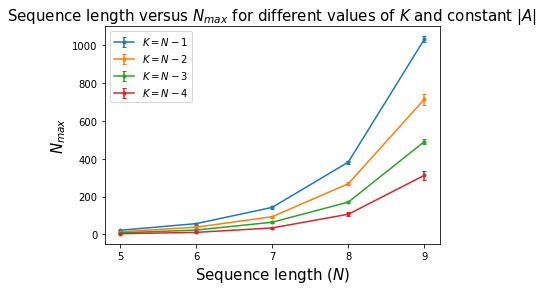

In [51]:
#_ = plt.figure(figsize=(10,7))

for i in range(len(res_means)):
    plt.errorbar(nvals, res_means[i], yerr=res_std[i], capsize=2,
                 marker='.', label='$K = N-{}$'.format(Ks[i]))
plt.title('Sequence length versus $N_{max}$ for different values of $K$ and constant $|A|$', fontsize=15)
plt.xlabel('Sequence length ($N$)', fontsize=15)
plt.ylabel('$N_{max}$', fontsize=15)
plt.xticks(nvals)

plt.legend()
plt.savefig('seq_len_vs_nmax_nonorm.svg')

### Normalising the data for sequence length

In [27]:
normalisation = lambda A, N: (A**N)/(N*(A-1)+1) #this is the function we will use for normalisation 

In [28]:
norm_matrix = np.array([normalisation(3, i) for i in nvals]) #obtain matrix that we will use to normalise 
#where does the above 2 come into play, I wonder...  It is just a scalar, nothing to worry,
#about, will still normalise


In [29]:
norm_matrix

array([  22.09090909,   56.07692308,  145.8       ,  385.94117647,
       1035.94736842])

In [30]:
#in the below array, the rows are different N values; in the columns, different -K values
res_means

array([[  21.7,   56.6,  142.8,  382.5, 1033.3],
       [  13.3,   38. ,   93.4,  268.2,  716. ],
       [   7.8,   22.7,   64.2,  170.7,  491.1],
       [   3.4,   10.5,   34. ,  106.5,  312.6]])

In [31]:
length_normalised = res_means/norm_matrix #normalise the result

In [33]:
length_normed_errors = np.multiply(length_normalised, percent_error)

In [36]:
length_normalised

array([[0.98230453, 1.00932785, 0.97942387, 0.99108368, 0.9974445 ],
       [0.60205761, 0.6776406 , 0.64060357, 0.69492455, 0.6911548 ],
       [0.35308642, 0.4048011 , 0.44032922, 0.44229538, 0.47405883],
       [0.15390947, 0.1872428 , 0.23319616, 0.27594879, 0.30175278]])

In [35]:
percent_error

array([[0.05847271, 0.10606594, 0.05458593, 0.0213116 , 0.01495546],
       [0.21543682, 0.13157895, 0.05749774, 0.02925436, 0.04037255],
       [0.13808115, 0.1672269 , 0.08778195, 0.0378797 , 0.02639982],
       [0.32751555, 0.18687064, 0.11391127, 0.10806284, 0.08024522]])

In [34]:
length_normed_errors

array([[0.05743801, 0.10705531, 0.05346276, 0.02112158, 0.01491724],
       [0.12970538, 0.08916324, 0.03683326, 0.02032957, 0.02790368],
       [0.04875458, 0.06769363, 0.03865296, 0.01675402, 0.01251507],
       [0.05040774, 0.03499018, 0.02656367, 0.02981981, 0.02421422]])

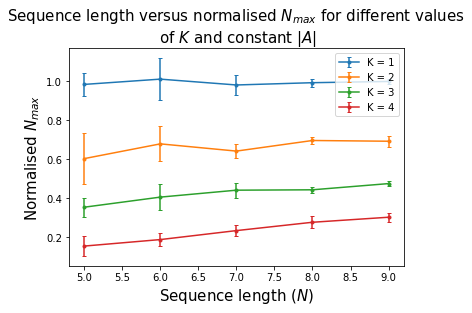

In [40]:


#_ = plt.figure(figsize=(10,7))

for i in range(len(length_normalised)):
    plt.errorbar(nvals, length_normalised[i], yerr=length_normed_errors[i],
                 marker='.', capsize=2, label='K = {}'.format(Ks[i]))
plt.title('Sequence length versus normalised $N_{max}$ for different values \n of $K$ and constant $|A|$', fontsize=15)
plt.xlabel('Sequence length ($N$)', fontsize=15)
plt.ylabel('Normalised $N_{max}$', fontsize=15)
plt.legend()

### Ruggedness correction

Due to the way the $NK$ landscape algorithm works, disparities in ruggedness (given by $K/N$) occur as $K$ and $N$ change; therefore, even within a single $K$ value in the above graph, the ruggedness is not equal, and this is reflected in a tendency for normalised $N_{max}$ to increase with sequence length (above). To correct for this, we calculate the ruggedness given $N$ and $K$, and normalise the length-normalised data. 

In [41]:
rugged_vals = np.array([i[1] for i in data]) #the second element contains the ruggedness values 

In [42]:
rugged_vals

array([[0.8       , 0.83333333, 0.85714286, 0.875     , 0.88888889],
       [0.6       , 0.66666667, 0.71428571, 0.75      , 0.77777778],
       [0.4       , 0.5       , 0.57142857, 0.625     , 0.66666667],
       [0.2       , 0.33333333, 0.42857143, 0.5       , 0.55555556]])

Clearly the actual ruggedness values (given by $K/N$) increase with $N$, just because that's how the NK model is set up. Note that we want to normalise across a given row. To do this, we take the minimum value across that row and divide it by the rest of the row. Then, to normalise given this, we simply take the reciprocal and multiply it by our calculated, length-normalised $N_{max}$.


In [43]:
rugged_norm_matrix = 1/np.divide(rugged_vals, np.min(rugged_vals, axis=1).reshape(-1,1)) #calculate min value of row, divide row by min value, then take the reciprocal of the whole matrix

In [44]:
length_ruggedness_normalised = np.multiply(length_normalised, rugged_norm_matrix) #calculate the final normalised data

In [46]:
final_error = np.multiply(length_ruggedness_normalised, percent_error)

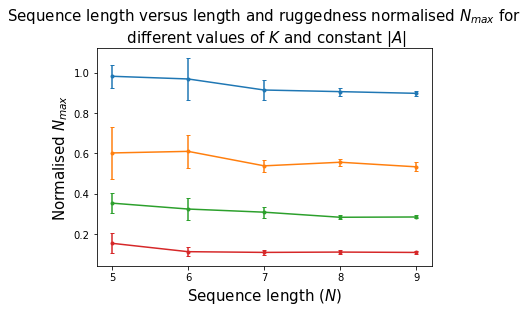

In [50]:

#_ = plt.figure(figsize=(10,7))

for i in range(len(length_ruggedness_normalised)):
    plt.errorbar(nvals, length_ruggedness_normalised[i], yerr=final_error[i], 
                 marker='.', capsize=2, label='$K = N-{}$'.format(Ks[i]))
plt.title('Sequence length versus length and ruggedness normalised $N_{max}$ for \n different values of $K$ and constant $|A|$', fontsize=15)
plt.xlabel('Sequence length ($N$)', fontsize=15)
plt.ylabel('Normalised $N_{max}$', fontsize=15)
plt.xticks(nvals)
plt.legend()
plt.savefig('seq_len_vs_nmax_normed_corrected.svg')

We note that the above 2 normalisation procedures (normalising for sequence length and for ruggedness) are commutative i.e. it does not matter which one we do first. We also note that the variance (i.e. the error) of $N_{max}$ decreases as sequence length increases, for all ruggedness values. Given that $|S| = |A|^N$, the sequence space size $|S|$ increases exponentially with $N$; further, recall that for $NK$ landscapes $\max N_{max} = \frac{|A|^N}{N+1}$, which is also exponential. We leave the remainder of the explanation as an exercise for the reader LOL. 

# Normalising for alphabet size $|A|$

In this section we want to determine and account for the effects of $|A|$ on $N_{max}$ for $NK$ landscapes. 

In [3]:
def run_NK_AA_replicates(K=2, N=3 ,alphabets=['AGC'], reps=10, dist=np.random.uniform): 
    REPL     = reps
    DIST     = np.random.uniform
    
    results = []
    landscapes = []
    
    for alph in alphabets: 
    
    
    
        repls = []
        for replicate in range(REPL):
            #print(N, N-K)
            landscape = make_NK(N, K, alph, np.random.uniform)
            landscapes.append(landscape)
            estimator = NMaximaEstimator(landscape, alph).fit()
            n_maxima  = estimator.n_maxima
            repls.append(n_maxima)
        results.append(repls)
        #ruggs.append((N-Kminus)/N)
        
    results = np.array(results)
    
    return results, landscapes

In [53]:
alphabet_list = ['AGC', 'AGCT', 'AGCTH', 'AGCTHL','AGCTHLY', 'AGCTHLYK', 'AGCTHLYKN', 'AGCTHLYKNW', 
                'AGCTHLYKNWR'] #alphabet list
cardinality_alphabet_list = [len(set(i)) for i in alphabet_list[1:]] #calculate cardinality of alphabet list 

Below, we produce replicate $NK$ landscapes at 4 increasing ruggedness values and increasing $|A|$. 

In [57]:
data2 = [run_NK_AA_replicates(K=i, N=4, alphabets=alphabet_list[1:]) for i in [0,1,2, 3]] 

In [58]:
results_2 = np.array([i[0] for i in data2])

In [59]:
#results_2 #the first dimension of this tensor array is K values -- we can see the unanimous presence of 1's in the 
            #very first array. Let's get the means and then plot

In [60]:
mean_results2    = np.mean(results_2, axis=2)
std_results2     = np.std(results_2, axis=2)
percent_err_res2 = np.divide(std_results2, mean_results2)

In [61]:
kvals = [0,1,2, 3] #initialise K vals list. Remember that N vals is constant in this experiment

Text(0.5, 1.0, 'Alphabet size $|A|$ and $N_{max}$ for different values of $K$ and constant $N$')

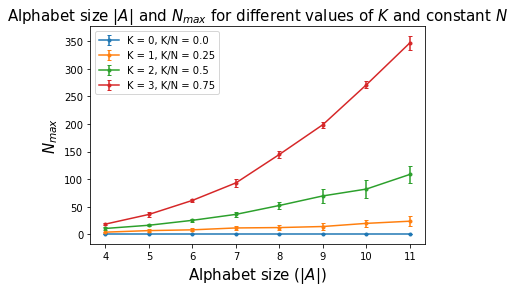

In [62]:
#_ = plt.figure(figsize=(10,7))
for i in range(len(mean_results2)): 
    plt.errorbar(cardinality_alphabet_list, mean_results2[i], yerr=std_results2[i], 
                 label='K = {}, K/N = {}'.format(kvals[i], kvals[i]/4), marker='.', capsize=2)
plt.legend()
plt.xlabel('Alphabet size ($|A|$)', fontsize=15)
plt.ylabel('$N_{max}$', fontsize=15)
plt.title('Alphabet size $|A|$ and $N_{max}$ for different values of $K$ and constant $N$', fontsize=15)


### Normalising for $|A|$

$K/N$ (ruggedness) seems to affect the exponentiality of the above graph. When ruggedness is 0, a constant value for $N_{max}$ is observed. How can we normalise here? Recall that $\max N_{max} = \frac{|A|^N}{N+1}$. Rather than changing $N$ in the equation like we did above, we can now change $|A|$. 












(**PROBLEM 1** -- this puts into question the whole enterprise  of trying to normalise for ruggedness doesn't it? If we only have one maxima in a landscape, but we have an exponentially larger landscape, how can we normalise? -- is the ruggedness of the latter landscape lower (which seems intuitive), given that we are dividing by such a large amount? Or is it simply a violation of statistical isotropy?  Because if we assume statistical isotropy, then it seems that the bigger landscape would indeed have lower ruggedness. Again, we run into problems regarding definitions of ruggedness.)

In [63]:
normalisation??

In [64]:
norm_A_matrix = np.array([len(i)**4/(4*(len(i)-1)+1) for i in alphabet_list[1:]])

In [65]:
norm_A_matrix

array([ 19.69230769,  36.76470588,  61.71428571,  96.04      ,
       141.24137931, 198.81818182, 270.27027027, 357.09756098])

In [66]:
norm_A_results = mean_results2/norm_A_matrix
norm_A_error   = np.multiply(norm_A_results, percent_err_res2)

Text(0.5, 1.0, 'Alphabet size $|A|$ and normalised $N_{max}$ for different values of $K$ and constant $N$')

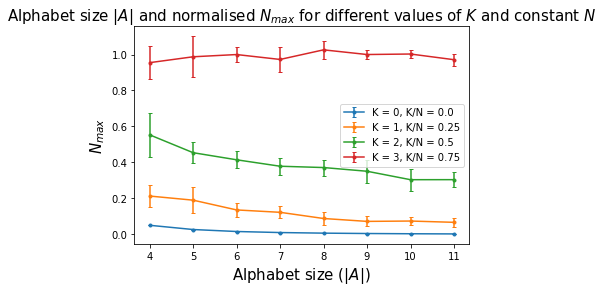

In [67]:
#_ = plt.figure(figsize=(10,7))
for i in range(len(mean_results2)): 
    plt.errorbar(cardinality_alphabet_list, norm_A_results[i], yerr=norm_A_error[i], 
                 label='K = {}, K/N = {}'.format(kvals[i], kvals[i]/4), marker='.', capsize=2)
plt.legend()
plt.xlabel('Alphabet size ($|A|$)', fontsize=15)
plt.ylabel('$N_{max}$', fontsize=15)
plt.title('Alphabet size $|A|$ and normalised $N_{max}$ for different values of $K$ and constant $N$', fontsize=15)


In [167]:
norm_A_results

array([[0.05078125, 0.0272    , 0.0162037 , 0.01041233, 0.00708008,
        0.00502972, 0.0037    , 0.00280036],
       [0.23359375, 0.16592   , 0.10856481, 0.11349438, 0.10195313,
        0.07896662, 0.07067   , 0.05768732],
       [0.50273437, 0.45968   , 0.44398148, 0.34777176, 0.35825195,
        0.32240512, 0.32708   , 0.28899665],
       [1.00546875, 1.04176   , 0.98032407, 0.98917118, 1.00253906,
        0.99437586, 0.98901   , 1.00196708]])